In [1]:
# Load data
import pandas as pd
import numpy as np

# Modeling
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load your parquet training dataset
df = pd.read_parquet("../data/train_NYC_inspection.parquet")

df.head()

,CUISINE DESCRIPTION,BORO,ZIPCODE,Latitude,Longitude,INSPECTION DATE,BUILDING,STREET,SCORE,GRADE
0,Chinese,Queens,11354.0,40.759778,-73.829235,2024-08-05,136-20,ROOSEVELT AVENUE,9.0,A
1,Coffee/Tea,Queens,11362.0,40.769834,-73.736180,2025-10-31,25201,NORTHERN BLVD,9.0,A
2,Japanese,Manhattan,10036.0,40.759161,-73.990369,2025-05-02,354,WEST 44 STREET,14.0,B
3,Pizza,Queens,11372.0,40.756245,-73.878681,2025-04-15,8906,NORTHERN BLVD,40.0,C
4,Chicken,Queens,11432.0,40.708211,-73.803110,2024-02-29,87-44,PARSONS BOULEVARD,20.0,None


In [2]:
# Data Cleaning

# Drop rows with missing target values (if any)
df = df.dropna(subset=["SCORE"])

# Optionally drop columns with too many missing values
missing_rate = df.isna().mean()
df = df.drop(columns=missing_rate[missing_rate > 0.5].index)

# Impute remaining missing numeric values with median
num_cols = df.select_dtypes(include=[np.number]).columns
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

In [3]:
# Define Features and Target

# Use SCORE as the regression target
target_col = "SCORE"

# Drop rows where the target is missing
df = df.dropna(subset=[target_col])

# Target
y = df[target_col].astype(float)

# Keep only numeric feature columns
num_cols = df.select_dtypes(include=["number"]).columns.drop(target_col)
X = df[num_cols].copy()

print("Number of numeric features:", len(num_cols))
print(num_cols[:10])

Number of numeric features: 3
Index(['ZIPCODE', 'Latitude', 'Longitude'], dtype='object')


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (102320, 3)
Test shape: (25580, 3)


In [ ]:
# Ridge Resgression Pipeline with Grid Search
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Hyperparameter grid
param_grid = {
    "ridge__alpha": [0.1, 1.0, 10.0] 
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
ridge_gs = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Fit the model
ridge_gs.fit(X_train, y_train)


,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'ridge__alpha': [0.1, 1.0, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [6]:
# Results of Opimization
print("Best alpha:", ridge_gs.best_params_["ridge__alpha"])
print("Best CV MSE:", -ridge_gs.best_score_)

Best alpha: 1.0
Best CV MSE: 391.9382188428091


In [7]:
# Evaluate on Test Set
best_ridge = ridge_gs.best_estimator_

y_pred = best_ridge.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", np.sqrt(mse))
print("Test R²:", r2)

Test MSE: 396.00947505684894
Test RMSE: 19.89998681046922
Test R²: 0.004992925026284567


In [8]:
# Coefficient Analysis

coeffs = pd.Series(
    best_ridge.named_steps["ridge"].coef_,
    index=X.columns
).sort_values(key=np.abs, ascending=False)

coeffs.head(20)

Latitude     8.780715
Longitude    8.265031
ZIPCODE      1.148905
dtype: float64

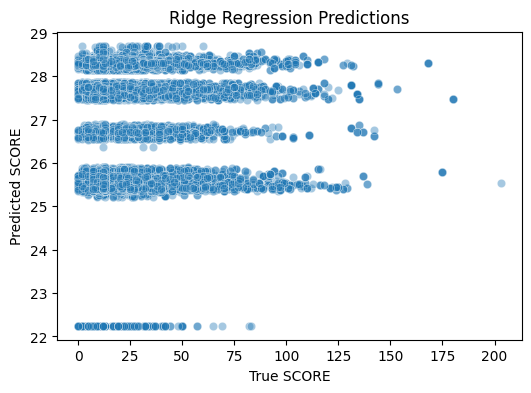

In [9]:
# Residual Plot
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("True SCORE")
plt.ylabel("Predicted SCORE")
plt.title("Ridge Regression Predictions")
plt.show()